In [1]:
import matplotlib.pyplot as plt    # import matplotlib
import numpy as np                 # import numpy
import scipy as sp                 # import scipy
import math                        # import basic math functions
import random
import sys
import seaborn as sns
import pandas  as pd
import gating_variables as gate

In [ ]:
# latency and sag definitions according to Desai and Varela 2021
# The latency was calculated as the time from the end of the negative current
# pulse to the peak of the first spike in the burst.
# we quantified the sag voltage (Figure 8(a)) during the hyperpolarization
#pulses by calculating the difference between the minimum membrane voltage
#at the start of the hyperpolarization pulse (≤125 ms) and at 250 ms after
#that minimum, based on the activation dynamics of Ih

# Functions

In [2]:
def init_isolatedTC(T, regime_name, k):
    '''input arguments: T: duration of simulation'''

    g_Na_TC=90 #90
    g_K_TC=10  #10
    g_T_TC=2
    # DEPENDS???


    if regime_name=="regime 1":
        ## how to add two choices here?? (think)
        g_L_TC=0.01
        g_KL_TC= 0
        g_H=0.015 #0.015
        I_bg=0

    elif regime_name=="spontaneous":
        g_L_TC=0.01
        g_KL_TC= 0.0172
        g_H=0.015
        I_bg=0


    elif regime_name=="test leaky":
        g_L_TC_list= list([0.01, 0.03, 0.05, 0.07, 0.09, 0.1])
        # g_L_TC_list=list([0.3, 0.4, 0.5])
        # g_L_TC_list=list([0.03, 0.06, 0.09]) # used this for comparing gLmax effect on burst latency
        g_KL_TC= 0
        g_H=0.015
        I_bg= 0
        g_L_TC= g_L_TC_list[k]
    elif regime_name=="test gH":
        g_H_list = list([0, 0.005, 0.01, 0.015, 0.02, 0.05, 0.1, 0.2, 0.5])
        g_L_TC=0.01
        g_KL_TC= 0
        I_bg=0
        g_H = g_H_list[k]




    Ca_conc=np.zeros(len(T))
#    Ca_conc[0]=0.002 #mM of calcium   ---> CHECK THIS INITIAL CONC.
    Ca_conc[0]=0.00 #mM of calcium   ---> CHECK THIS INITIAL CONC.


    V_Na_TC=50
    V_K_TC=-100
    V_H=-43 #mV
    V_L_TC=-70 #(changed from -70 mV)
    V_T_TC = 120 # used this instead of using the dynamic equation in Austin Sopalata 2017
    V_KL_TC= -100

    # membrane potential at each time point
    V_TC=np.zeros(len(T))
    V_TC[0]=-60 #change between 0 to -60 or -65 to Vleak value i.e, -70

    #current contributed by ion channels in each time point
    I_K_TC=np.zeros(len(T)) # Potassium
    I_Na_TC=np.zeros(len(T)) # Sodium
    I_L_TC=np.zeros(len(T)) # k Leaky channels
    I_KL_TC= np.zeros(len(T)) # k Leaky channels
    I_H_TC=np.zeros(len(T))
    I_T_TC=np.zeros(len(T))


    # open probabilities of each channel gates at each time point
    n_TC=np.zeros(len(T))
    m_TC=np.zeros(len(T))
    h_TC=np.zeros(len(T))
    S_H_TC=np.zeros(len(T))
    F_H_TC=np.zeros(len(T))

     #initial rate values for K and Na rate equations
    n_TC[0]=gate.alpha_n_TRN(V_TC[0])/(gate.alpha_n_TRN(V_TC[0])+gate.beta_n_TRN(V_TC[0]))
    m_TC[0]=gate.alpha_m_TRN(V_TC[0])/(gate.alpha_m_TRN(V_TC[0])+gate.beta_m_TRN(V_TC[0]))
    h_TC[0]=gate.alpha_h_TRN(V_TC[0])/(gate.alpha_h_TRN(V_TC[0])+gate.beta_h_TRN(V_TC[0]))
    alpha_S_TC_0= gate.H_TC_inf(V_TC[0])/gate.tau_H_S(V_TC[0])
    beta_S_TC_0= (1-gate.H_TC_inf(V_TC[0]))/gate.tau_H_S(V_TC[0])
    S_H_TC[0]= alpha_S_TC_0/(alpha_S_TC_0 + beta_S_TC_0)

    alpha_F_TC_0= gate.H_TC_inf(V_TC[0])/gate.tau_H_F(V_TC[0])
    beta_F_TC_0= (1-gate.H_TC_inf(V_TC[0]))/gate.tau_H_F(V_TC[0])
    F_H_TC[0]= alpha_F_TC_0/(alpha_F_TC_0 + beta_F_TC_0)


    #initial rate values for
    m_Ca_TC=np.zeros(len(T))
    h_Ca_TC=np.zeros(len(T))

    m_Ca_TC[0]=gate.m_Ca_TC_inf(0)
    h_Ca_TC[0]=gate.h_Ca_TC_inf(0)

    return g_Na_TC, g_K_TC, g_T_TC, g_L_TC, g_H, g_KL_TC, I_bg, V_Na_TC, V_K_TC, V_T_TC, V_L_TC, V_H, V_KL_TC, V_TC, I_K_TC, I_Na_TC, I_L_TC, I_T_TC,I_H_TC, I_KL_TC, n_TC, m_TC, h_TC, m_Ca_TC, h_Ca_TC, S_H_TC, F_H_TC

In [3]:
def generateburstsTC(I,T,C_m,dt,regime_name,k):


        allvariables_TC={}

        g_Na_TC, g_K_TC, g_T_TC, g_L_TC, g_H, g_KL_TC, I_bg, V_Na_TC, V_K_TC, V_T_TC, V_L_TC, V_H, V_KL_TC, V_TC, I_K_TC, I_Na_TC, I_L_TC, I_T_TC,I_H_TC, I_KL_TC, n_TC, m_TC, h_TC, m_Ca_TC, h_Ca_TC, S_H_TC, F_H_TC =init_isolatedTC(T, regime_name, k)

        print(g_L_TC)
        print(g_H)
        I=I

        for i in range(len(T)-1):

            I_K_TC[i]= g_K_TC*np.power(n_TC[i],4)*(V_TC[i]-V_K_TC)/C_m

            I_Na_TC[i]=g_Na_TC*np.power(m_TC[i],3)*h_TC[i]*(V_TC[i]-V_Na_TC)/C_m

            I_L_TC[i]=g_L_TC*(V_TC[i]-V_L_TC)/C_m

            I_KL_TC[i]=g_KL_TC*(V_TC[i]-V_KL_TC)/C_m

            I_T_TC[i]=g_T_TC*np.power(m_Ca_TC[i],2)*h_Ca_TC[i]*(V_TC[i]-V_T_TC)/C_m

            I_H_TC[i]=g_H*S_H_TC[i]*F_H_TC[i]*(V_TC[i]-V_H)/C_m


            V_TC[i+1]=(I[i]/C_m-I_K_TC[i]-I_L_TC[i]-I_T_TC[i]-I_Na_TC[i]-I_H_TC[i]-I_KL_TC[i])*dt+V_TC[i]



            n_TC[i+1]=-(n_TC[i]-gate.n_inf(V_TC[i]))*dt/gate.tau_n(V_TC[i]) +n_TC[i]

            m_TC[i+1]=-(m_TC[i]-gate.m_inf(V_TC[i]))*dt/gate.tau_m(V_TC[i]) +m_TC[i]

            h_TC[i+1]=-(h_TC[i]-gate.h_inf(V_TC[i]))*dt/gate.tau_h(V_TC[i]) +h_TC[i]

            m_Ca_TC[i+1]= gate.m_Ca_TC_inf(V_TC[i+1])

            h_Ca_TC[i+1]=-(h_Ca_TC[i]-gate.h_Ca_TC_inf(V_TC[i]))*dt/gate.tau_Ca_TC_h(V_TC[i]) +h_Ca_TC[i]

            S_H_TC[i+1]= -(S_H_TC[i]-gate.H_TC_inf(V_TC[i]))*dt/gate.tau_H_S(V_TC[i]) + S_H_TC[i]

            F_H_TC[i+1]= -(F_H_TC[i]-gate.H_TC_inf(V_TC[i]))*dt/gate.tau_H_F(V_TC[i]) + F_H_TC[i]

        allvariables_TC = {'Injected current (μA)': I, 'n_K':n_TC, 'h_Na':h_TC, 'm_Na':m_TC, 'I_T (nA)':I_T_TC, 'm_Ca_TC': m_Ca_TC, 'h_Ca_TC':h_Ca_TC,'I_h (nA)':I_H_TC, 'slow state variable': S_H_TC, 'fast state variable':F_H_TC, 'Membrane potential (mV)':V_TC}

        return allvariables_TC



In [4]:
def generatespikes(V_pre,V_th,T,dt):

    spike=[]
    print(np.dtype(spike))
    # spike_train=[]
    spike_train=np.zeros(len(T))
    i=0
    count=0
    while i < len(T):
        if V_pre[i]>=V_th:

    #         print(V_TC[i+1], i+1)
            spike= np.append(spike,(i)*dt)
            spike_train[i]=1
            i=i+200
            count+=1
            # print(i)
            # if k==len(T):
            #     StopIteration
        i+=1

    return spike_train, spike

In [5]:
def duration_of_sim (t_start, t_end, dt):
   '''
   input parameters:
      other parameters: time step for simulation , dt : 0.001 (change the dt value as per choice)
      C_m: capacitance per unit area, important to divie the current by capacitance per unit area to get the

   '''
   T = np.arange(t_start, t_end+dt, dt)
   return T
# capacitance per unit area of neuron (microF/cm^2)
C_m=1


In [6]:
def inputcurrent(i_mean,u,sigma,t_end,dt):
    # for t =t_max

    i=i_mean*(1+sigma*math.sqrt(t_end/dt)*(2*u-1))
    return i

In [7]:
def I_input(t, dt, p, a):
  #p = period
  i = 0
  I = np.ones(len(t))*0
  c = -0.05
  cnt = 0
  while i<len(t):
    # if cnt % 5 ==0:
    #   i+=int(500/dt)
    #   cnt+=1
    #   continue
    if i>4860/dt:
      #I[i+int(30/dt):len(t)] = 1
      break
    # if i>4000/dt:
    #   print('test')
    #   I[i+int(70/dt):i+int(90/dt)] = -1.2
    else:
      I[i+int(30/dt):i+int(100/dt)] = a
    i+=int(p/dt)
    c-=0.05
    cnt += 1
  return I
# T= duration_of_sim(0, 2000, dt=0.01)
# I = I_input(T, 0.01, 200)
# plt.plot(T, I)

#gh tested

In [8]:
# calculate all variables for different gh (see value in g_H_list)
T= duration_of_sim(0, 1000, dt=0.01)
dt = 0.01
I_TCinput = I_input(T, 0.01, 300, -0.6)

#g_H_list = list([0, 0.005, 0.01, 0.015, 0.02, 0.05, 0.1, 0.2, 0.5])

allvariables_TC_test0=generateburstsTC(I_TCinput,T,C_m, dt=0.01, regime_name="test gH",k=0)
allvariables_TC_test1=generateburstsTC(I_TCinput,T,C_m, dt=0.01, regime_name="test gH",k=1)
allvariables_TC_test2=generateburstsTC(I_TCinput,T,C_m, dt=0.01, regime_name="test gH",k=2)
allvariables_TC_test3=generateburstsTC(I_TCinput,T,C_m, dt=0.01, regime_name="test gH",k=3)
allvariables_TC_test4=generateburstsTC(I_TCinput,T,C_m, dt=0.01, regime_name="test gH",k=4)
allvariables_TC_test5=generateburstsTC(I_TCinput,T,C_m, dt=0.01, regime_name="test gH",k=5)
allvariables_TC_test6=generateburstsTC(I_TCinput,T,C_m, dt=0.01, regime_name="test gH",k=6)
allvariables_TC_test7=generateburstsTC(I_TCinput,T,C_m, dt=0.01, regime_name="test gH",k=7)
allvariables_TC_test8=generateburstsTC(I_TCinput,T,C_m, dt=0.01, regime_name="test gH",k=8)

0.01
0
0.01
0.005
0.01
0.01
0.01
0.015
0.01
0.02
0.01
0.05
0.01
0.1
0.01
0.2
0.01
0.5


Text(0, 0.5, 'Membrane potential (mV)')

<Figure size 640x480 with 0 Axes>

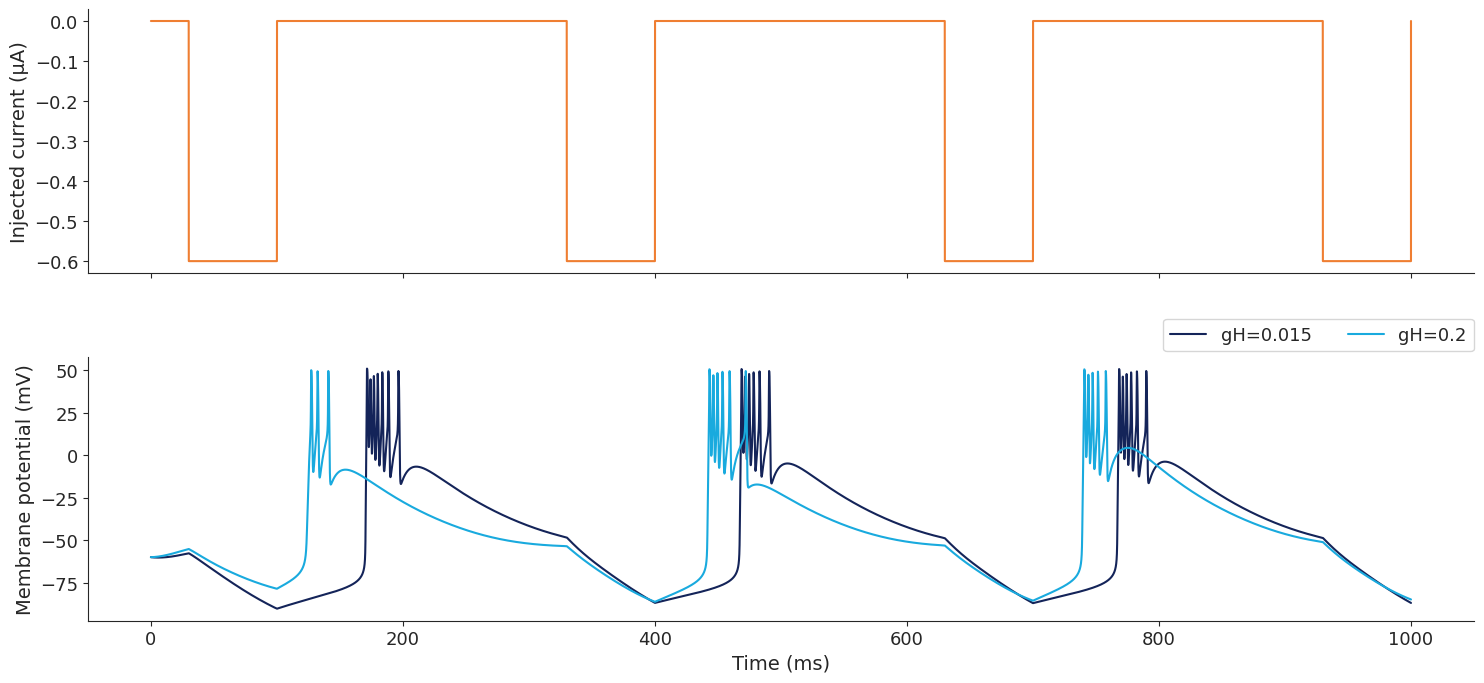

In [11]:
#plot 2 values for gh
sns.set_style('ticks') # darkgrid, white grid, dark, white and ticks
sns.despine()  #does not seem to work
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=12)          # controls default text sizes
sns.color_palette('deep')[0]
plt.figure(figsize=(15,7), tight_layout=True) #7,5 is better for shorter plots


V_TC0= allvariables_TC_test1['Membrane potential (mV)']
I0=allvariables_TC_test1['Injected current (μA)']

V_TC1= allvariables_TC_test3['Membrane potential (mV)']
I1=allvariables_TC_test3['Injected current (μA)']

V_TC2= allvariables_TC_test7['Membrane potential (mV)']
I2=allvariables_TC_test7['Injected current (μA)']

plt.subplot(2,1,1)
plt.plot(T,I2, color= '#EF7E32')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(color='w')
plt.ylabel('Injected current (μA)')

plt.subplot(2,1,2)

plt.plot(T,V_TC1,label='gH=0.015', color='#142459')
plt.plot(T,V_TC2,label='gH=0.2', color='#19AADE')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=4,
           ncol=2, borderaxespad=0.)

plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')

(400.0, 525.0)

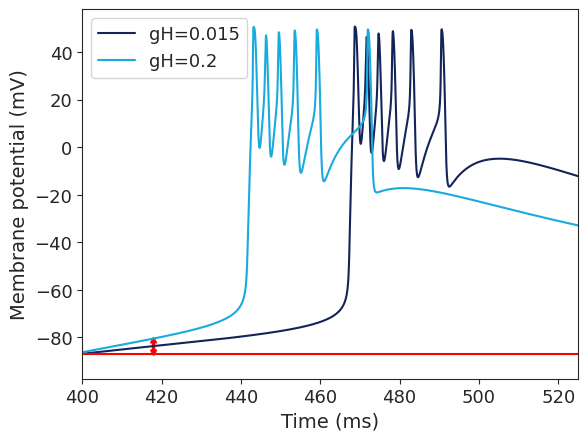

In [12]:
# zoom in
plt.plot(T,V_TC1,label='gH=0.015', color='#142459')
plt.plot(T,V_TC2,label='gH=0.2', color='#19AADE')
plt.axhline(y = -86.9, color = 'r')
plt.arrow(418, -86.9 , 0, 6.85,width=0.5, head_width=1.5, length_includes_head=True, color='r')
plt.arrow(418, -86.9+2.3, 0, -3, width=0.5, head_width=1.5, length_includes_head=True, color='r')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.legend()
plt.xlim(400, 525)

#Latency vs gh vs sag voltage

In [13]:
# calculate latency and sag for all gh conditions
V_TC = {}
V_TC0= allvariables_TC_test1['Membrane potential (mV)']
I0=allvariables_TC_test1['Injected current (μA)']
V_TC['V_TC0'] = V_TC0

V_TC1= allvariables_TC_test2['Membrane potential (mV)']
I1=allvariables_TC_test2['Injected current (μA)']
V_TC['V_TC1'] = V_TC1

V_TC2= allvariables_TC_test3['Membrane potential (mV)']
I2=allvariables_TC_test3['Injected current (μA)']
V_TC['V_TC2'] = V_TC2

V_TC3= allvariables_TC_test4['Membrane potential (mV)']
I3=allvariables_TC_test4['Injected current (μA)']
V_TC['V_TC3'] = V_TC3

V_TC4= allvariables_TC_test5['Membrane potential (mV)']
I4=allvariables_TC_test5['Injected current (μA)']
V_TC['V_TC4'] = V_TC4

V_TC5= allvariables_TC_test6['Membrane potential (mV)']
I5=allvariables_TC_test6['Injected current (μA)']
V_TC['V_TC5'] = V_TC5

V_TC6= allvariables_TC_test7['Membrane potential (mV)']
I6=allvariables_TC_test7['Injected current (μA)']
V_TC['V_TC6'] = V_TC6

V_TC7= allvariables_TC_test8['Membrane potential (mV)']
I7=allvariables_TC_test8['Injected current (μA)']
V_TC['V_TC7'] = V_TC7

V_TC8= allvariables_TC_test0['Membrane potential (mV)']
I8=allvariables_TC_test0['Injected current (μA)']
V_TC['V_TC8'] = V_TC8
latency = {}
sag = {}
i_end_hp = int(400/dt)
for i in range(9):
  V_TCi = 'V_TC' + str(i)
  i_peak_burst = np.argmax(V_TC[V_TCi][i_end_hp:i_end_hp+int(100/dt)]) + i_end_hp
  latency[V_TCi] = (i_peak_burst - i_end_hp)*dt
  sag[V_TCi] = V_TC[V_TCi][i_end_hp+int(20/dt)] - V_TC[V_TCi][i_end_hp]

0.9664892778933983


Text(0.1, 85, 'R² = 0.9665')

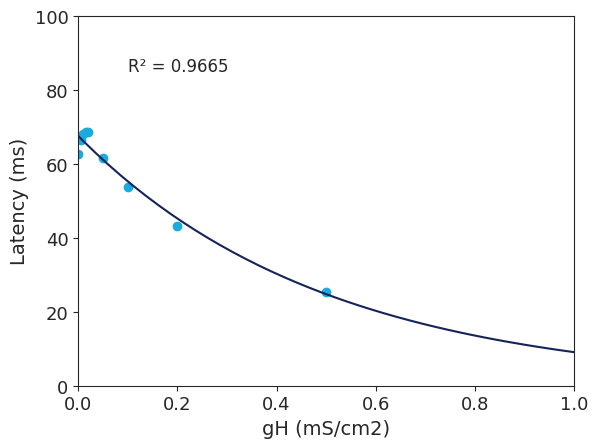

In [14]:
# gh vs latency
g_H_list = list([0.005, 0.01, 0.015, 0.02, 0.05, 0.1, 0.2, 0.5, 0])
plt.scatter(g_H_list, latency.values(), color = "#19AADE")
plt.xlabel('gH (mS/cm2)')
plt.ylabel('Latency (ms)')

# fit and calculate r**2
x = g_H_list
y = list(latency.values())
p = np.polyfit(x, np.log(y), 1)
a = np.exp(p[1])
b = p[0]
x_fitted = np.linspace(np.min(x)-1, np.max(x)+1, 100)
y_fitted = a * np.exp(b * x_fitted)
plt.plot(x_fitted, y_fitted, color = '#142459')
plt.xlim(0, 1)
plt.ylim(0, 100)
x = np.array(x)
y_fitted = a * np.exp(b * x)
corr_matrix = np.corrcoef(y, y_fitted)
corr = corr_matrix[0,1]
R_sq = corr**2
print(R_sq)
plt.text(0.1, 85, f'R² = {R_sq:.4f}')
#plt.legend()

0.9944753620156144


Text(0.1, 18, 'R² = 0.9945')

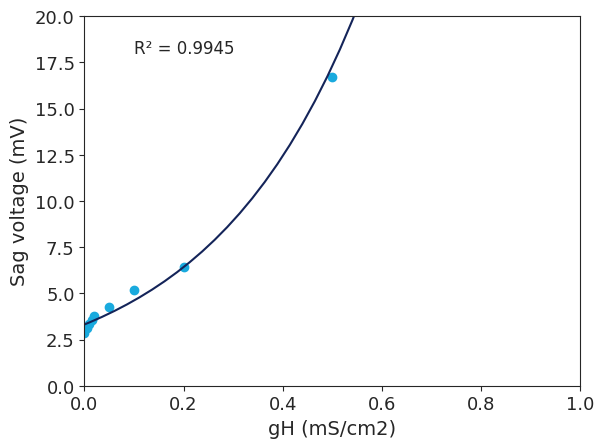

In [15]:
# gh vs sag
g_H_list = list([0.005, 0.01, 0.015, 0.02, 0.05, 0.1, 0.2, 0.5, 0])
plt.scatter(g_H_list, sag.values(), color = "#19AADE")
plt.xlabel('gH (mS/cm2)')
plt.ylabel('Sag voltage (mV)')

# fit and calculate r**2
x = g_H_list
y = list(sag.values())
p = np.polyfit(x, np.log(y), 1)
a = np.exp(p[1])
b = p[0]
x_fitted = np.linspace(np.min(x)-1, np.max(x)+1, 100)
y_fitted = a * np.exp(b * x_fitted)
plt.plot(x_fitted, y_fitted, color = '#142459')
plt.xlim(0, 1)
plt.ylim(0, 20)
x = np.array(x)
y_fitted = a * np.exp(b * x)
corr_matrix = np.corrcoef(y, y_fitted)
corr = corr_matrix[0,1]
R_sq = corr**2
print(R_sq)
plt.text(0.1, 18, f'R² = {R_sq:.4f}')
#plt.legend()

0.9039243422932023


Text(3, 30, 'R² = 0.9039')

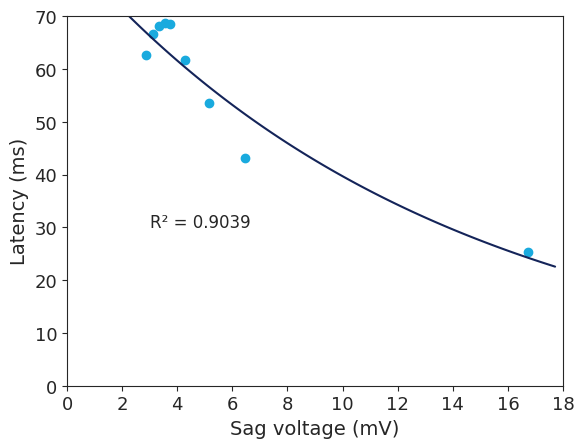

In [16]:
# sag vs latency
x = list(sag.values())
y = list(latency.values())
plt.scatter(x, y, color = "#19AADE")
plt.ylabel('Latency (ms)')
plt.xlabel('Sag voltage (mV)')

# fit and calculate r**2
p = np.polyfit(x, np.log(y), 1)
a = np.exp(p[1])
b = p[0]
x_fitted = np.linspace(np.min(x)-1, np.max(x)+1, 100)
y_fitted = a * np.exp(b * x_fitted)
plt.plot(x_fitted, y_fitted, color = '#142459')
plt.xlim(0, 18)
plt.ylim(0, 70)
x = np.array(x)
y_fitted = a * np.exp(b * x)
corr_matrix = np.corrcoef(y, y_fitted)
corr = corr_matrix[0,1]
R_sq = corr**2
print(R_sq)

plt.text(3, 30, f'R² = {R_sq:.4f}')